<a href="https://colab.research.google.com/github/Ramyavijaykumar/ANN_HeartSoundClassification_LSTMRNN/blob/main/LSTM_HEARTBEAT_HARMONICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.14.0
keras version:  2.14.0


In [3]:
# parent folder of sound files
INPUT_DIR="/content/heartsound/input"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12

In [4]:
# check what is inside each directory and content
!pwd
!ls -all /content/heartsound/input/

/content
total 148
drwxr-xr-x 5 root root  4096 Dec  7 05:05 .
drwxr-xr-x 4 root root  4096 Dec  7 05:05 ..
drwxr-xr-x 2 root root  4096 Dec  7 05:05 .ipynb_checkpoints
drwxr-xr-x 2 root root 12288 Dec  7 05:06 set_app
-rw-r--r-- 1 root root  7735 Dec  7 05:05 set_app.csv
-rw-r--r-- 1 root root 17895 Dec  7 05:05 set_app_timing.csv
drwxr-xr-x 2 root root 49152 Dec  7 05:07 set_clinic
-rw-r--r-- 1 root root 48705 Dec  7 05:05 set_clinic.csv


In [5]:
set_app=pd.read_csv(INPUT_DIR+"/set_app.csv")
set_app.head()

dataset                               fname     label  sublabel
0     app  set_app/artifact__201012172012.wav  artifact       NaN
1     app  set_app/artifact__201105040918.wav  artifact       NaN
2     app  set_app/artifact__201105041959.wav  artifact       NaN
3     app  set_app/artifact__201105051017.wav  artifact       NaN
4     app  set_app/artifact__201105060108.wav  artifact       NaN

In [6]:
set_app_timing=pd.read_csv(INPUT_DIR+"/set_app_timing.csv")
set_app_timing.head()

fname  cycle sound  location
0  set_app/normal__201102081321.wav      1    S1     10021
1  set_app/normal__201102081321.wav      1    S2     20759
2  set_app/normal__201102081321.wav      2    S1     35075
3  set_app/normal__201102081321.wav      2    S2     47244
4  set_app/normal__201102081321.wav      3    S1     62992

In [7]:
set_clinic=pd.read_csv(INPUT_DIR+"/set_clinic.csv")
set_clinic.head()

dataset                                              fname       label  \
0  clinic  set_clinic/Btraining_extrastole_127_1306764300...  extrastole   
1  clinic  set_clinic/Btraining_extrastole_128_1306344005...  extrastole   
2  clinic  set_clinic/Btraining_extrastole_130_1306347376...  extrastole   
3  clinic  set_clinic/Btraining_extrastole_134_1306428161...  extrastole   
4  clinic  set_clinic/Btraining_extrastole_138_1306762146...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [8]:
#merge both set-app and set-clinic
frames = [set_app, set_clinic]
train_ab=pd.concat(frames)
train_ab.describe()

dataset                               fname   label     sublabel
count      832                                 832     585          149
unique       2                                 832       5            2
top     clinic  set_app/artifact__201012172012.wav  normal  noisynormal
freq       656                                   1     351          120

In [9]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


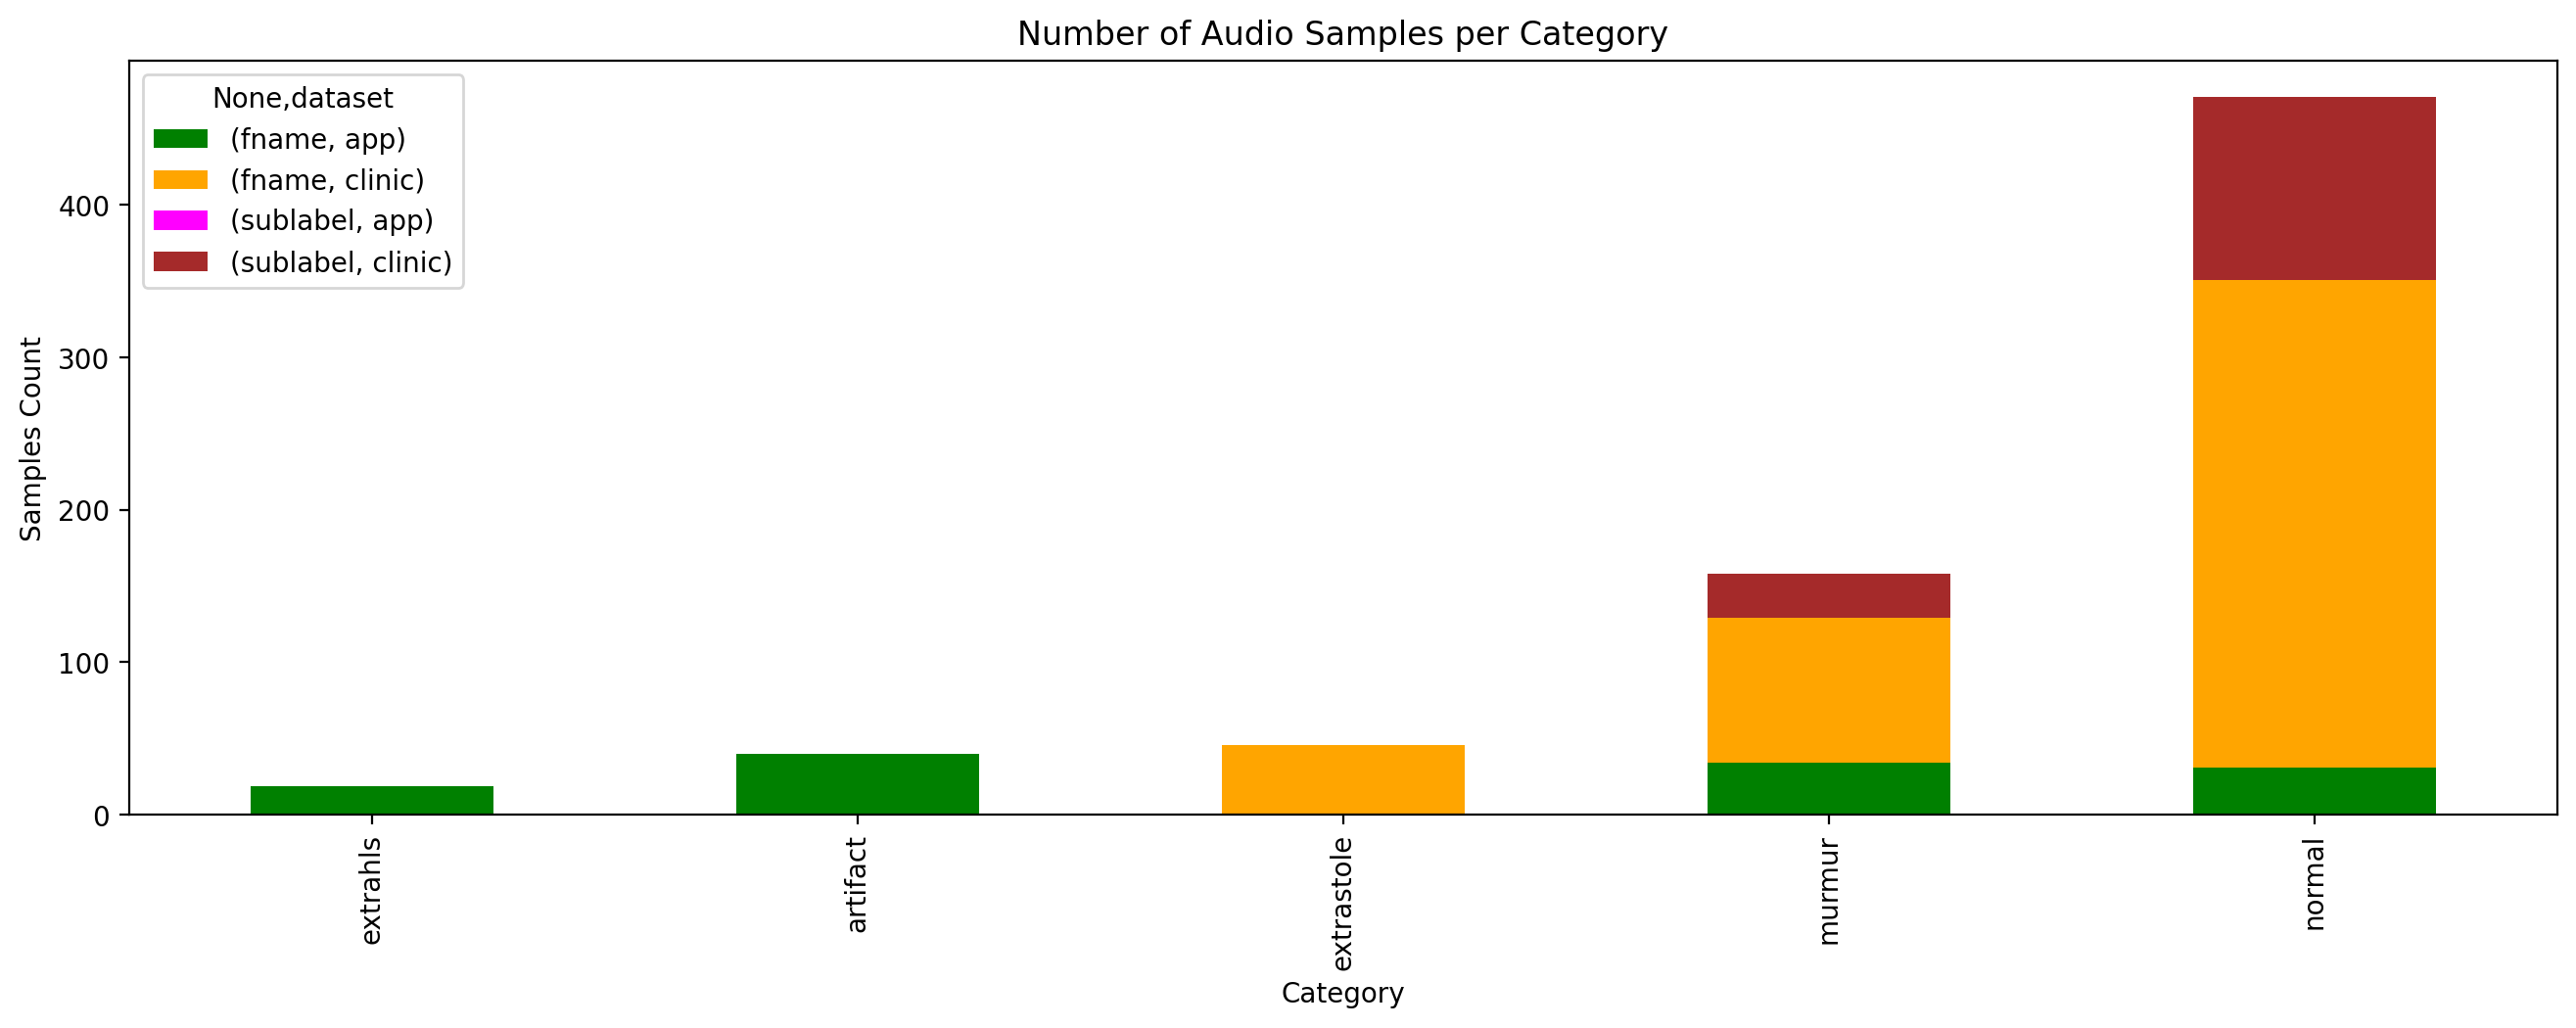

In [10]:
# visualize data distribution by category
import matplotlib.pyplot as plt

# Define custom colors for each category
colors = ['green', 'orange', 'magenta', 'brown', 'orange', 'cyan', 'magenta', 'brown', 'gray', 'pink']

# Visualize data distribution by category
category_group = train_ab.groupby(['label', 'dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
    .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16, 5), color=colors)

plot.set_xlabel("Category")
plot.set_ylabel("Samples Count")

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

plt.show()

**Normal**

In [11]:
normal_file=INPUT_DIR+"/set_app/normal__201106111136.wav"

In [12]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file)

In [13]:
# Load use wave
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [14]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


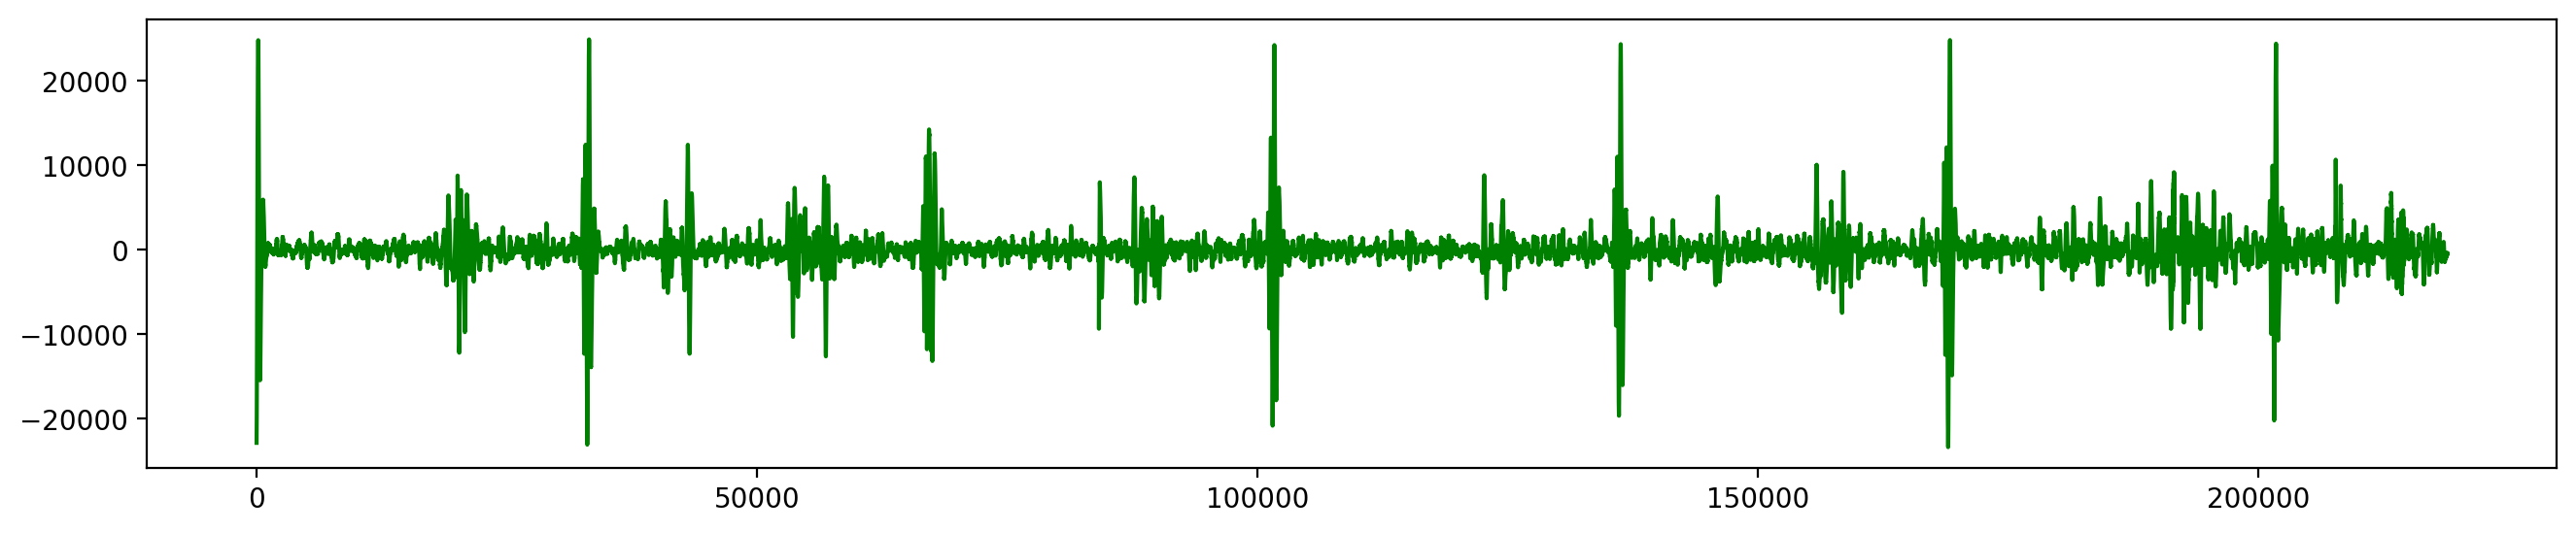

In [15]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', color="green");

In [16]:
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur = librosa.get_duration(y=y, sr=sr)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


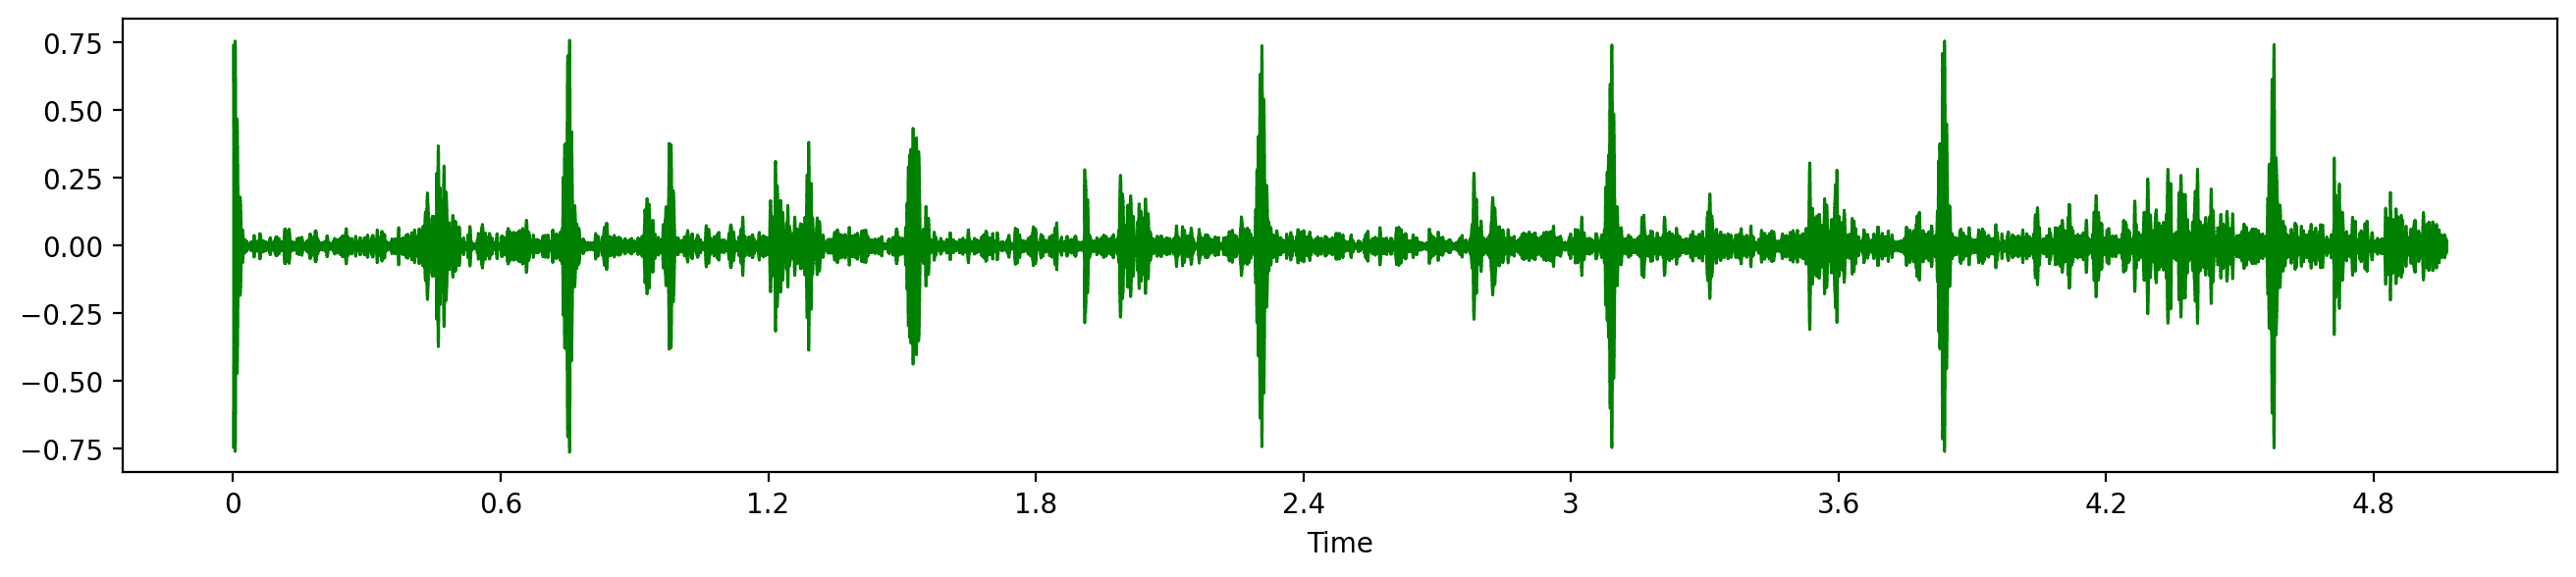

In [17]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr, color="green")

**Murmur**

In [18]:
# murmur case
murmur_file=INPUT_DIR+"/set_app/murmur__201108222251.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [19]:
import IPython.display as ipd
ipd.Audio(murmur_file)

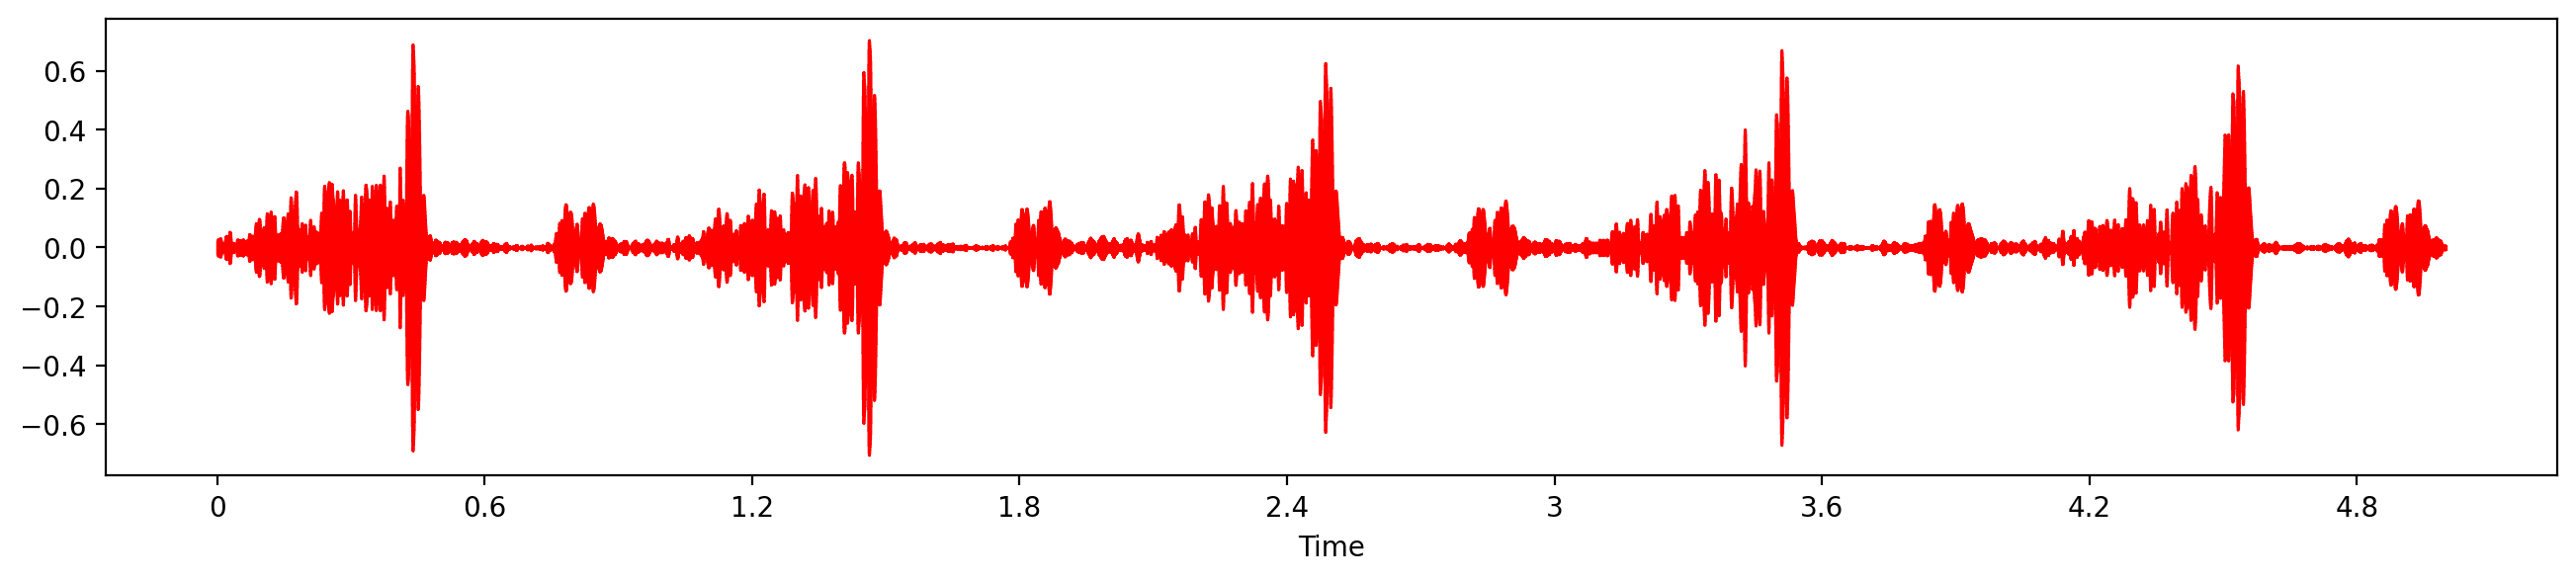

In [20]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y2, sr=sr2, color="Red")

**Extrasystole case**

In [21]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_clinic/extrastole__261_1309353556003_C.wav"
y3, sr3 = librosa.load(extrastole_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y3.shape,sr3)

duration: 4.963809523809524
(110250,) 22050


In [22]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file)

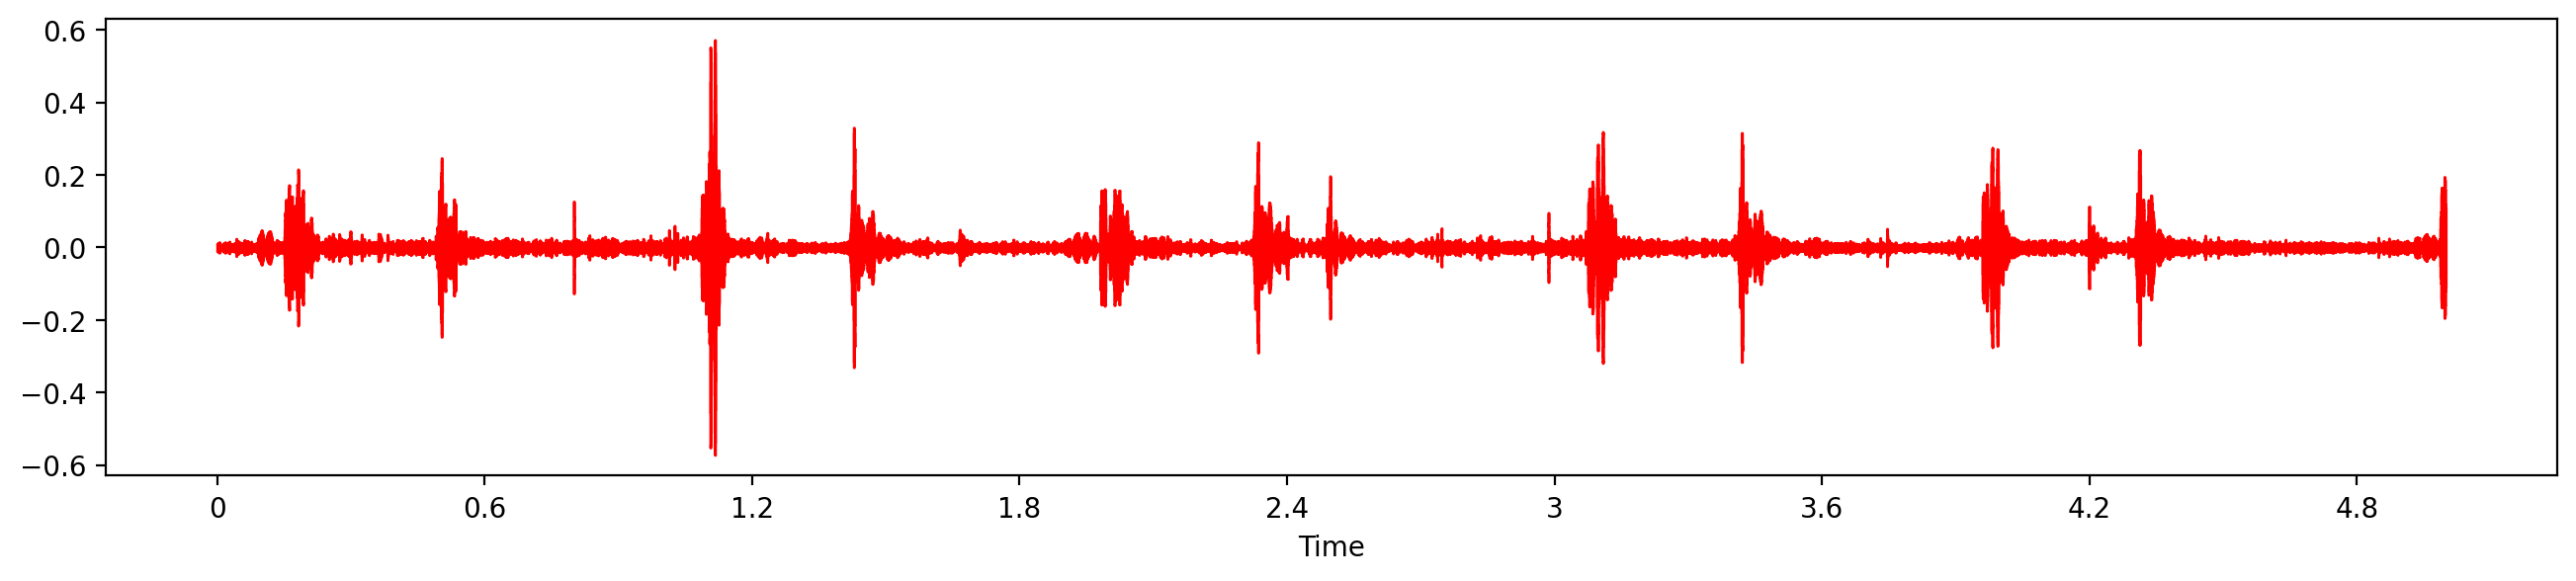

In [23]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y3, sr=sr3, color="red")

**Artifact**

In [24]:
#Artifact
artifact_file=INPUT_DIR+"/set_app/artifact__201106110909.wav"
y4, sr4 = librosa.load(artifact_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 4.963809523809524
(110250,) 22050


In [25]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file)

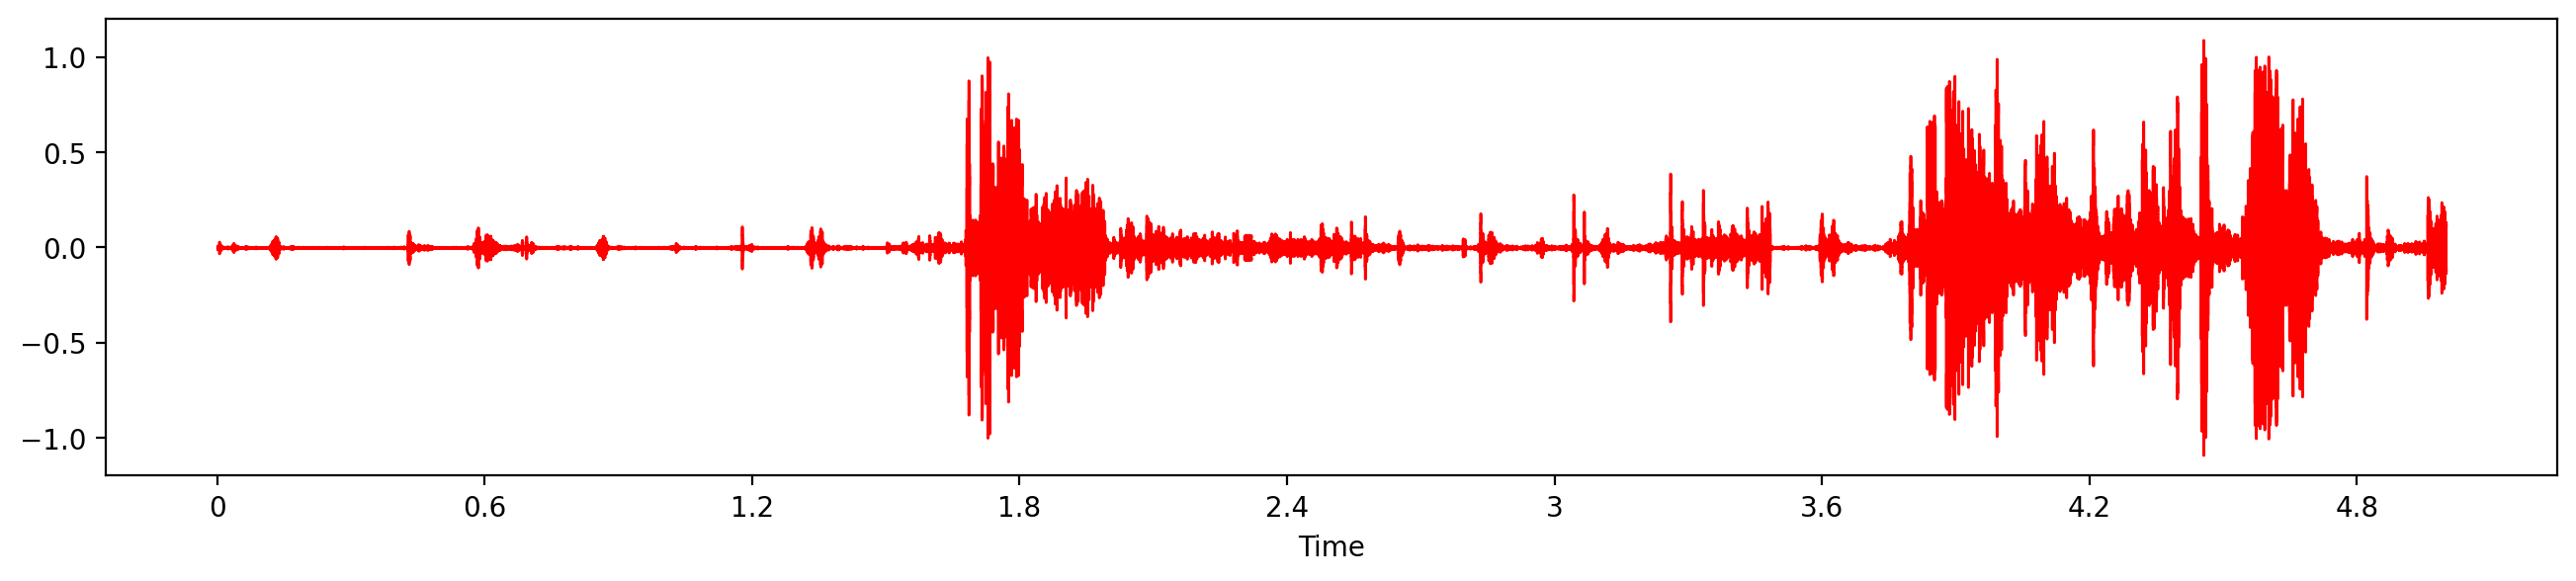

In [26]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y4, sr=sr4, color="red")

**Extra Heart Sound**

In [27]:
# Extra Heart Sound
extrahls_file=INPUT_DIR+"/set_app/extrahls__201102241217.wav"
y5, sr5 = librosa.load(extrahls_file, duration=5)
dur=librosa.get_duration(y=y)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 4.963809523809524
(110250,) 22050


In [28]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file)

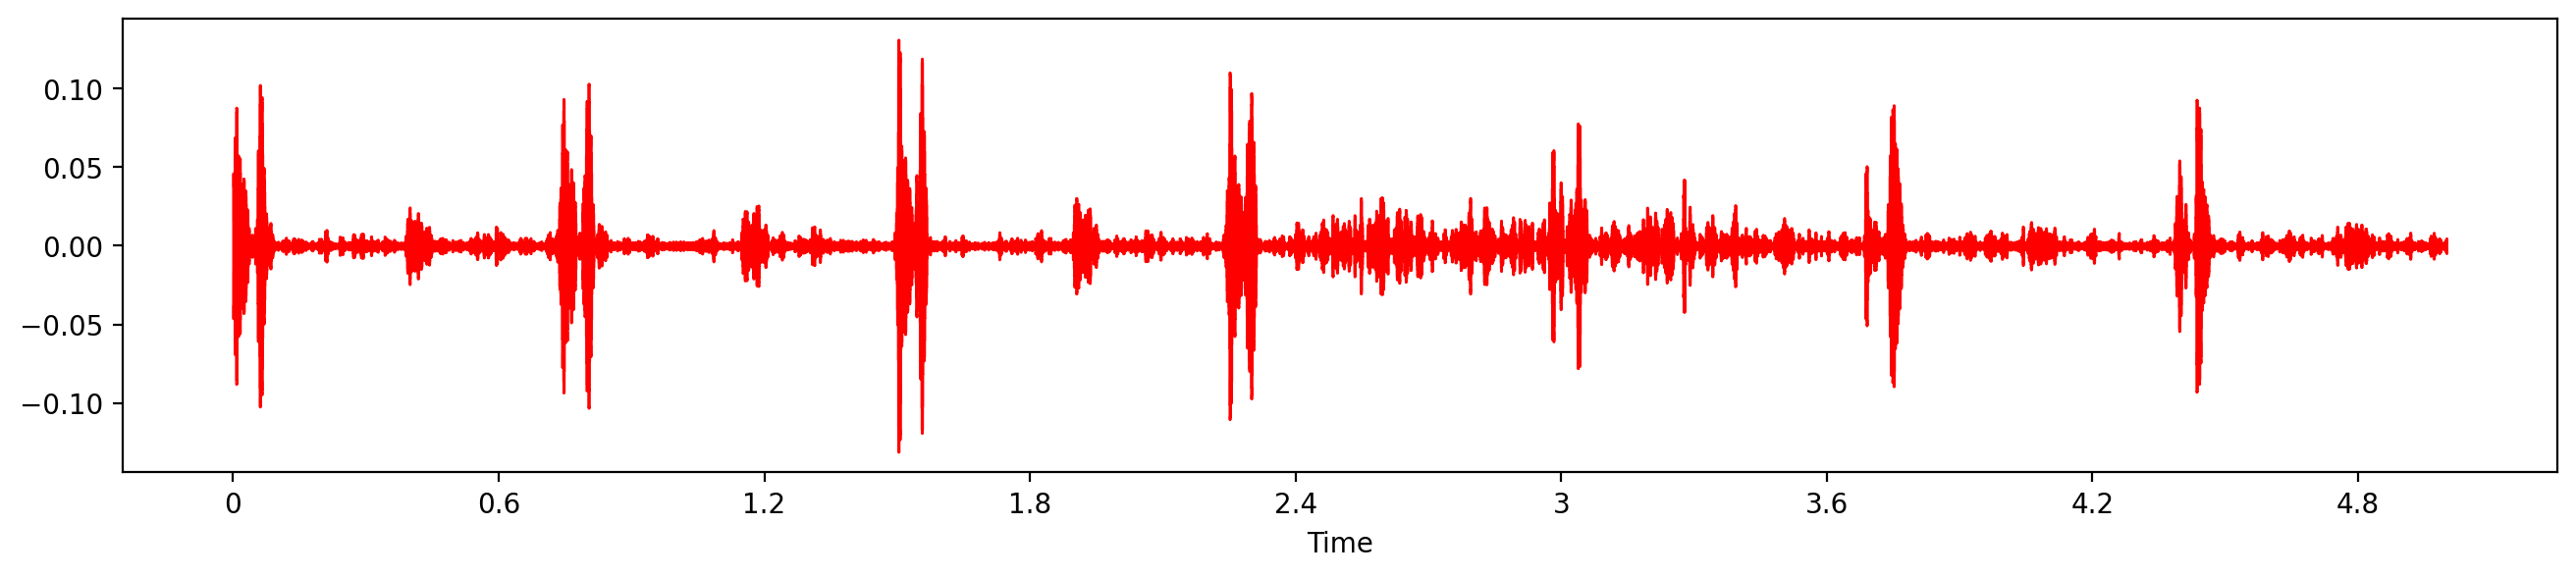

In [29]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y5, sr=sr5, color="Red")

**Sound Feature:MFCC**

In [30]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_app/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-8.1913383e+01 -1.4807559e+02 -4.0729141e+02 ... -3.6786765e+02
  -3.7412061e+02 -3.7847031e+02]
 [ 1.2379559e+02  1.2622456e+02  1.3922583e+02 ...  1.5123857e+02
   1.6177921e+02  1.6117076e+02]
 [ 1.7456497e+01  1.9744457e+01  1.9956833e+01 ...  2.9298073e+01
   2.5672840e+01  3.3723251e+01]
 ...
 [-7.1166635e-01 -1.5279514e-01 -1.3570656e+00 ... -2.9591602e-01
   3.5141253e-01  2.2013893e+00]
 [-2.7901683e+00 -2.1342328e+00  4.8859596e-02 ...  2.5581994e+00
   3.4908652e-03  5.4476895e+00]
 [-1.3884723e-01  3.3570039e-01 -2.9419873e+00 ...  2.3936687e+00
  -1.4753829e+00  3.3484679e-01]]


In [31]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.1982685e+01 -1.2800836e+02 -3.9028296e+02 ... -3.5058392e+02
  -3.5407178e+02 -3.5892279e+02]
 [ 1.1376016e+02  1.1646743e+02  1.3576584e+02 ...  1.4986195e+02
   1.5767870e+02  1.5809064e+02]
 [ 2.1968613e+01  2.4365150e+01  1.1875887e+01 ...  2.0178364e+01
   1.8738571e+01  2.7622364e+01]
 ...
 [-1.3763438e+00 -7.9267144e-01 -2.0632422e+00 ...  2.9104042e+00
  -1.4185039e+00  1.5542839e+00]
 [-2.6494286e+00 -2.2966690e+00 -3.4821877e+00 ...  1.3711340e+00
   3.4652799e-02 -1.5800276e+00]
 [-4.1403532e+00 -4.1632414e+00 -1.6855989e+00 ...  4.1955805e-01
   6.4381826e-01 -3.5052786e+00]]


In [32]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

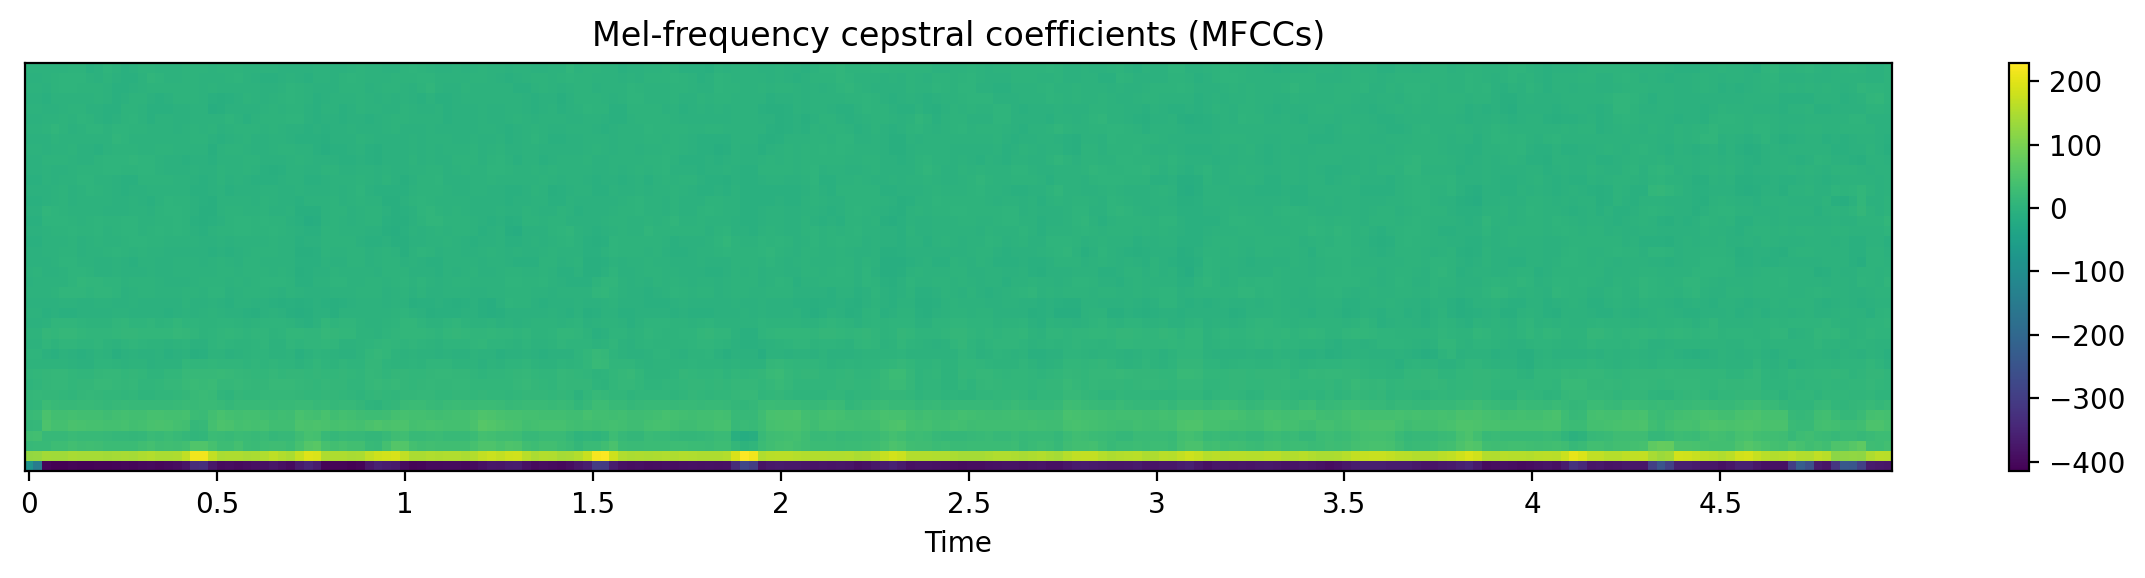

In [33]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
colormap = 'viridis'
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time', cmap=colormap)
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

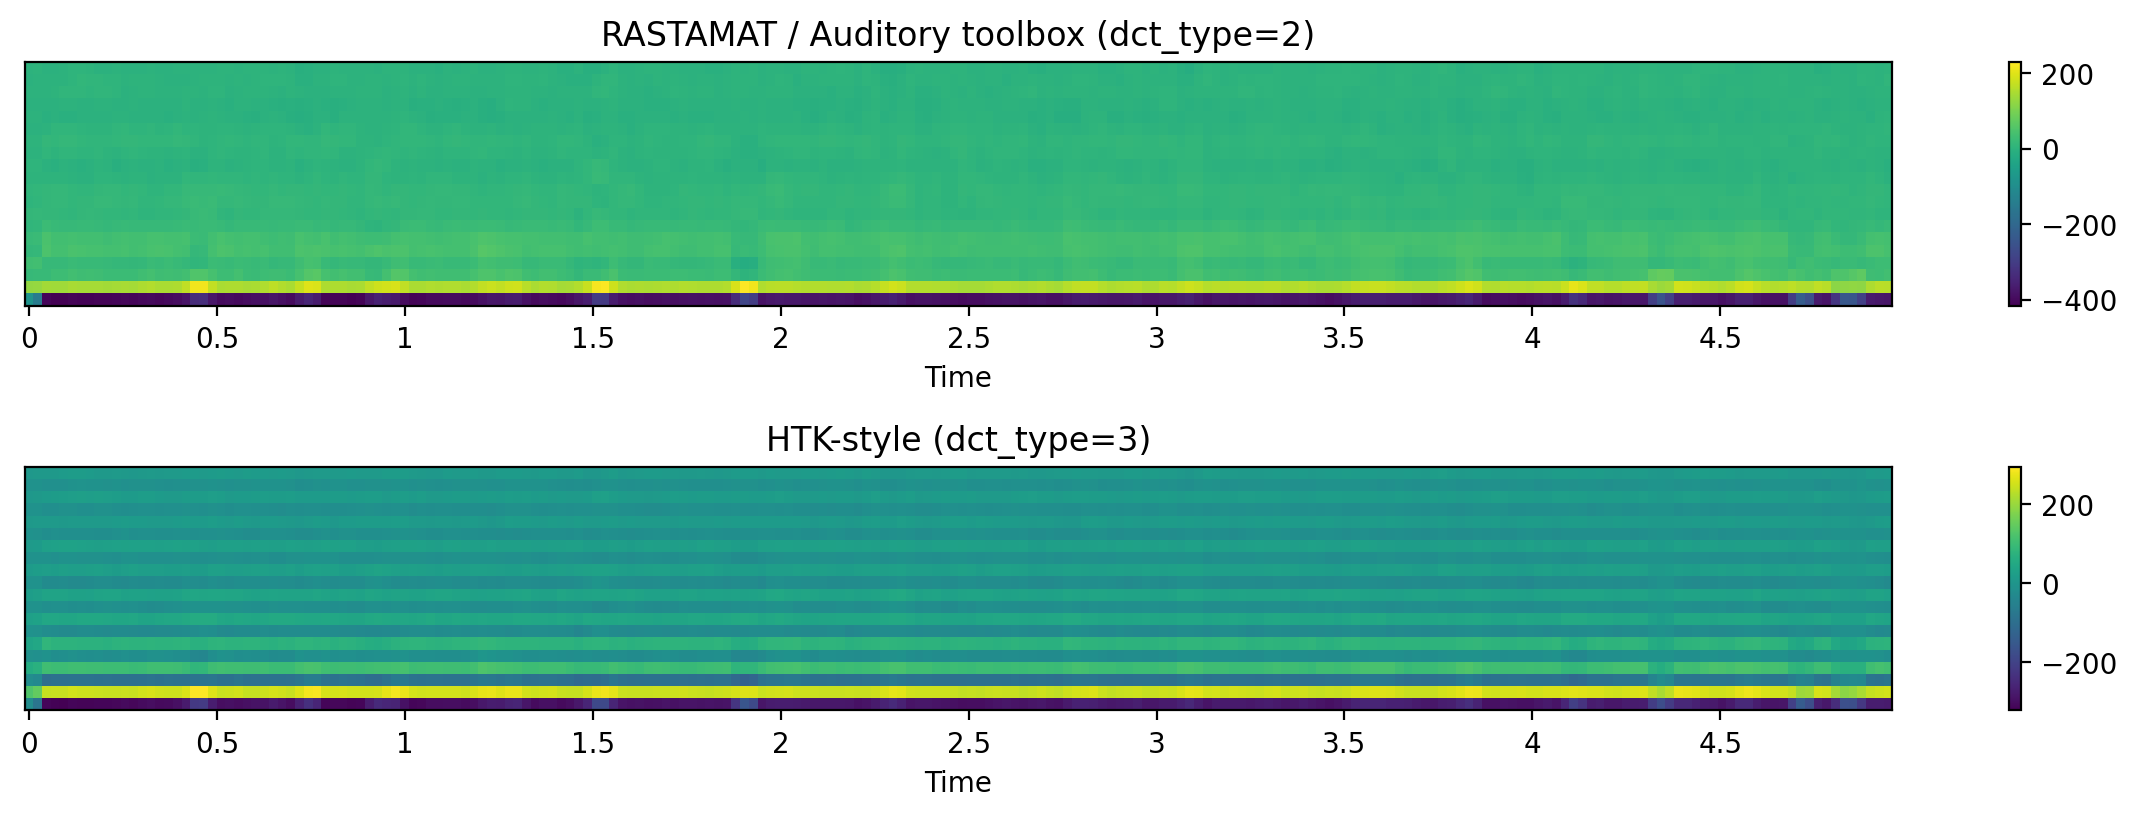

In [34]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)

#m_dct1 = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(m_dct1, x_axis='time')
#plt.title('Discrete cosine transform (dct_type=1)')
#plt.colorbar()
colormap = 'viridis'
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time', cmap=colormap)
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time', cmap=colormap)
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

**Sound Feature: Onset**

In [35]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.80807256,
       3.85451247, 4.13315193, 4.36535147, 4.59755102, 4.73687075,
       4.85297052])

In [36]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

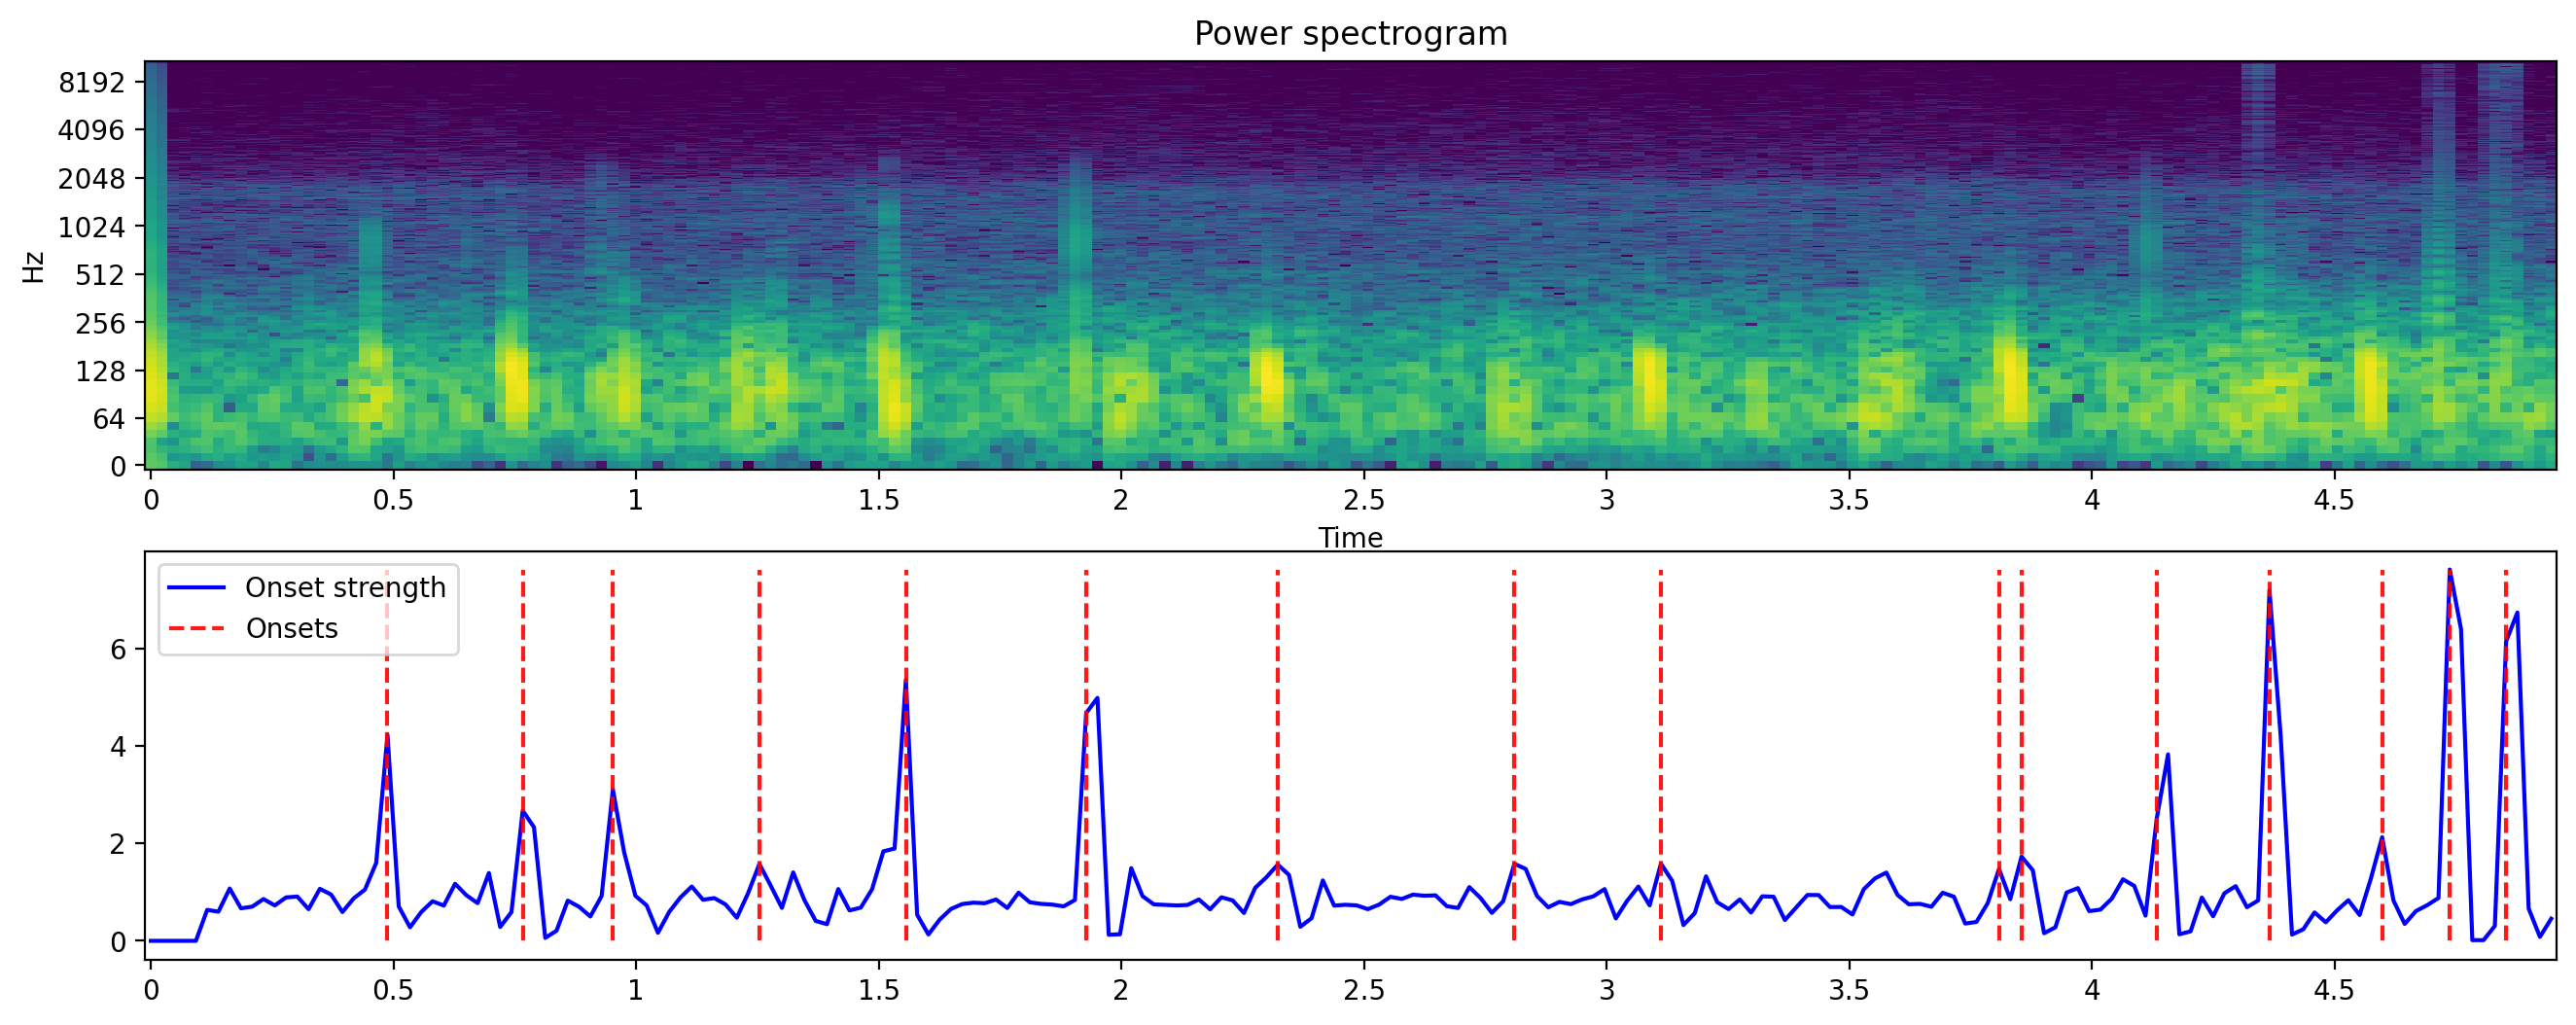

In [37]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
colormap_spectrogram = 'viridis'
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log',
                         cmap=colormap_spectrogram)
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength', color='blue')
plt.vlines(times[onset_frames], 0, o_env.max(), color='red', alpha=0.9,linestyle='--',
           label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

**Onset backtrack**

In [38]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

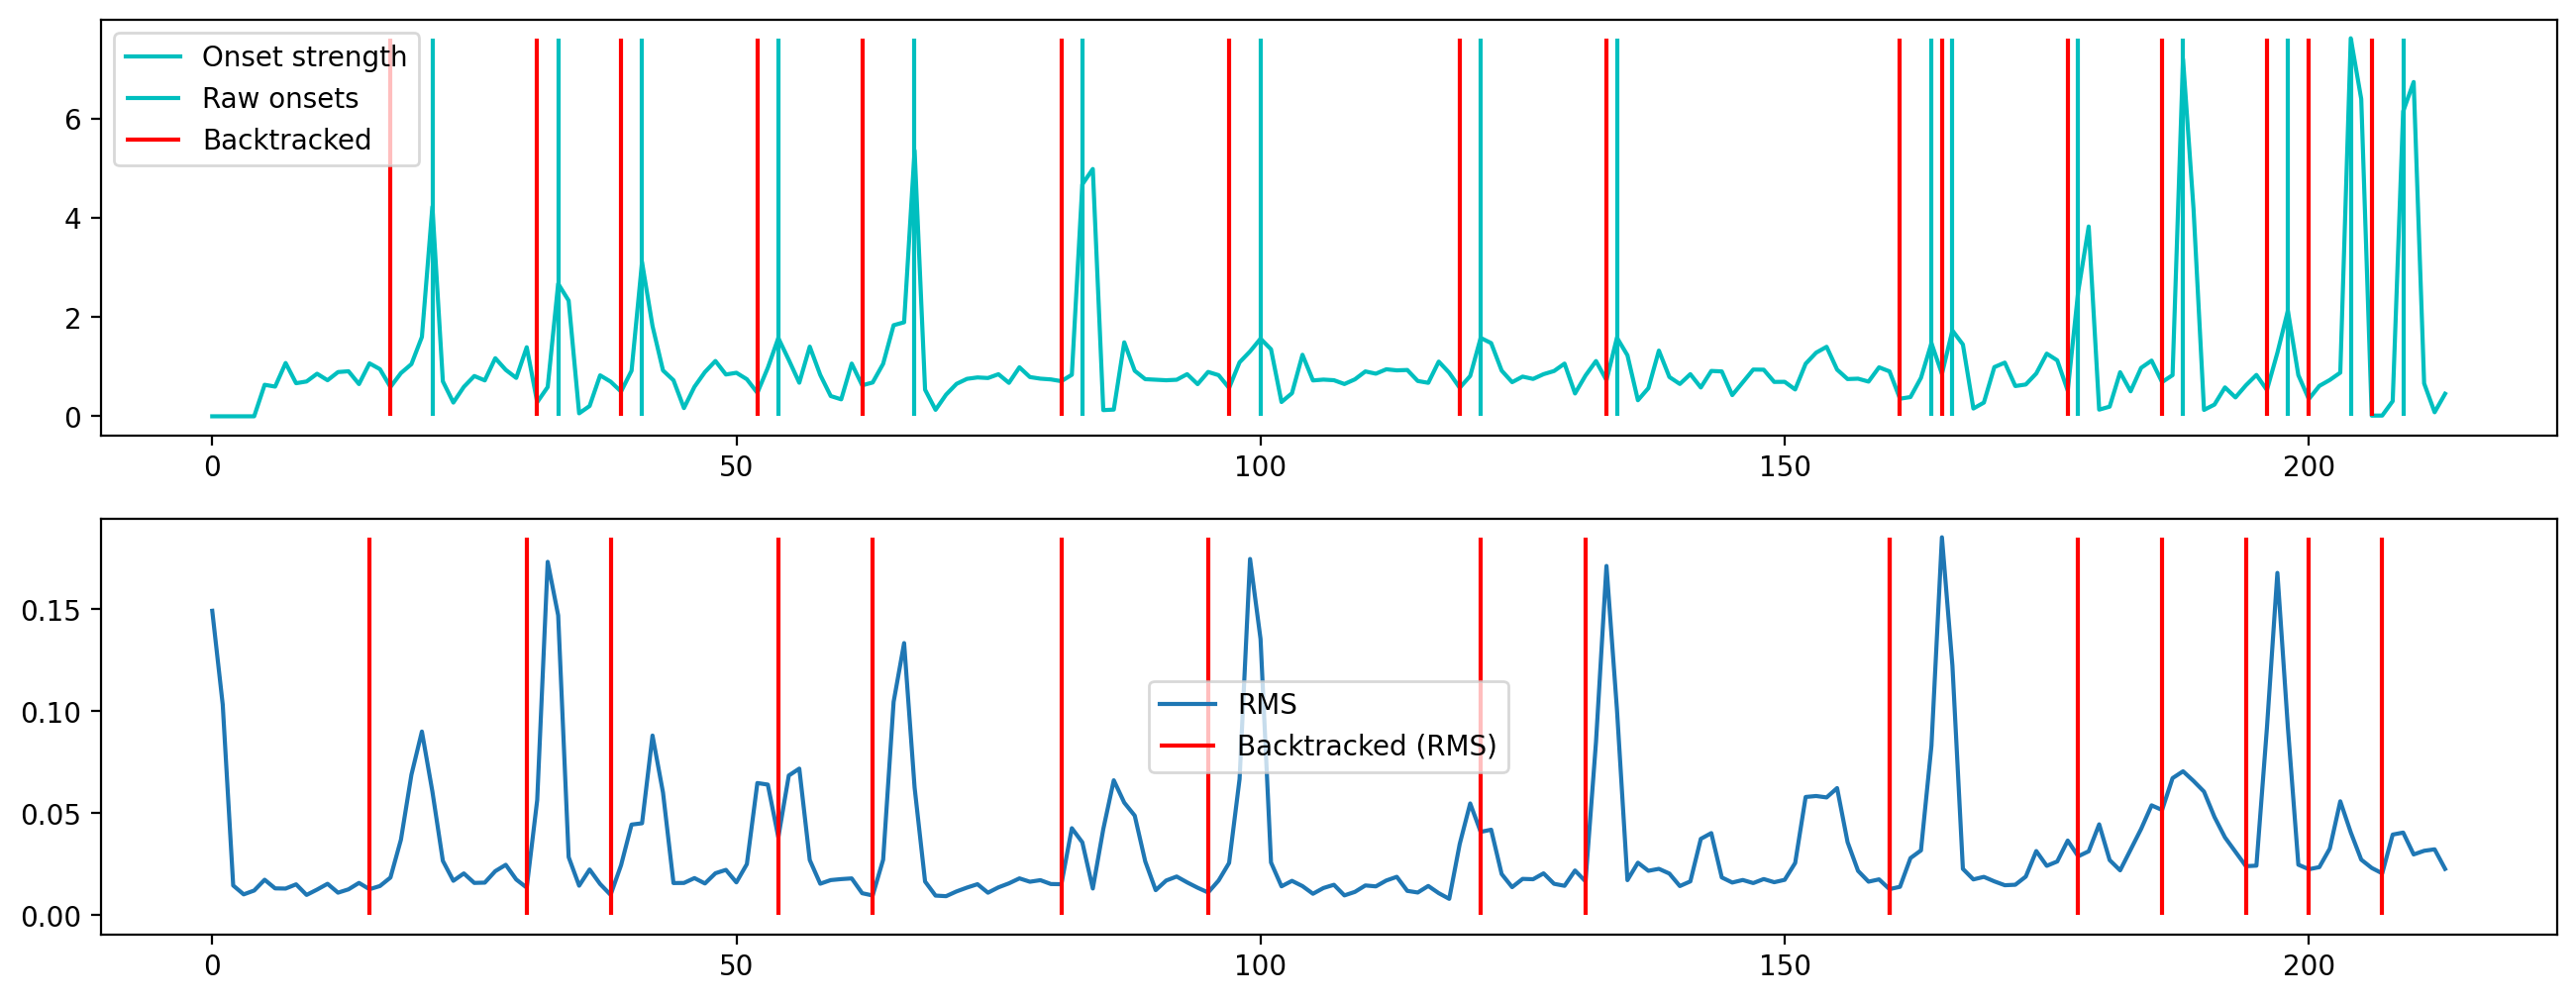

In [39]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength',color='c')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets',color='c')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)


**Onset Strength**

Text(0.5, 1.0, 'Sub-band onset strength')

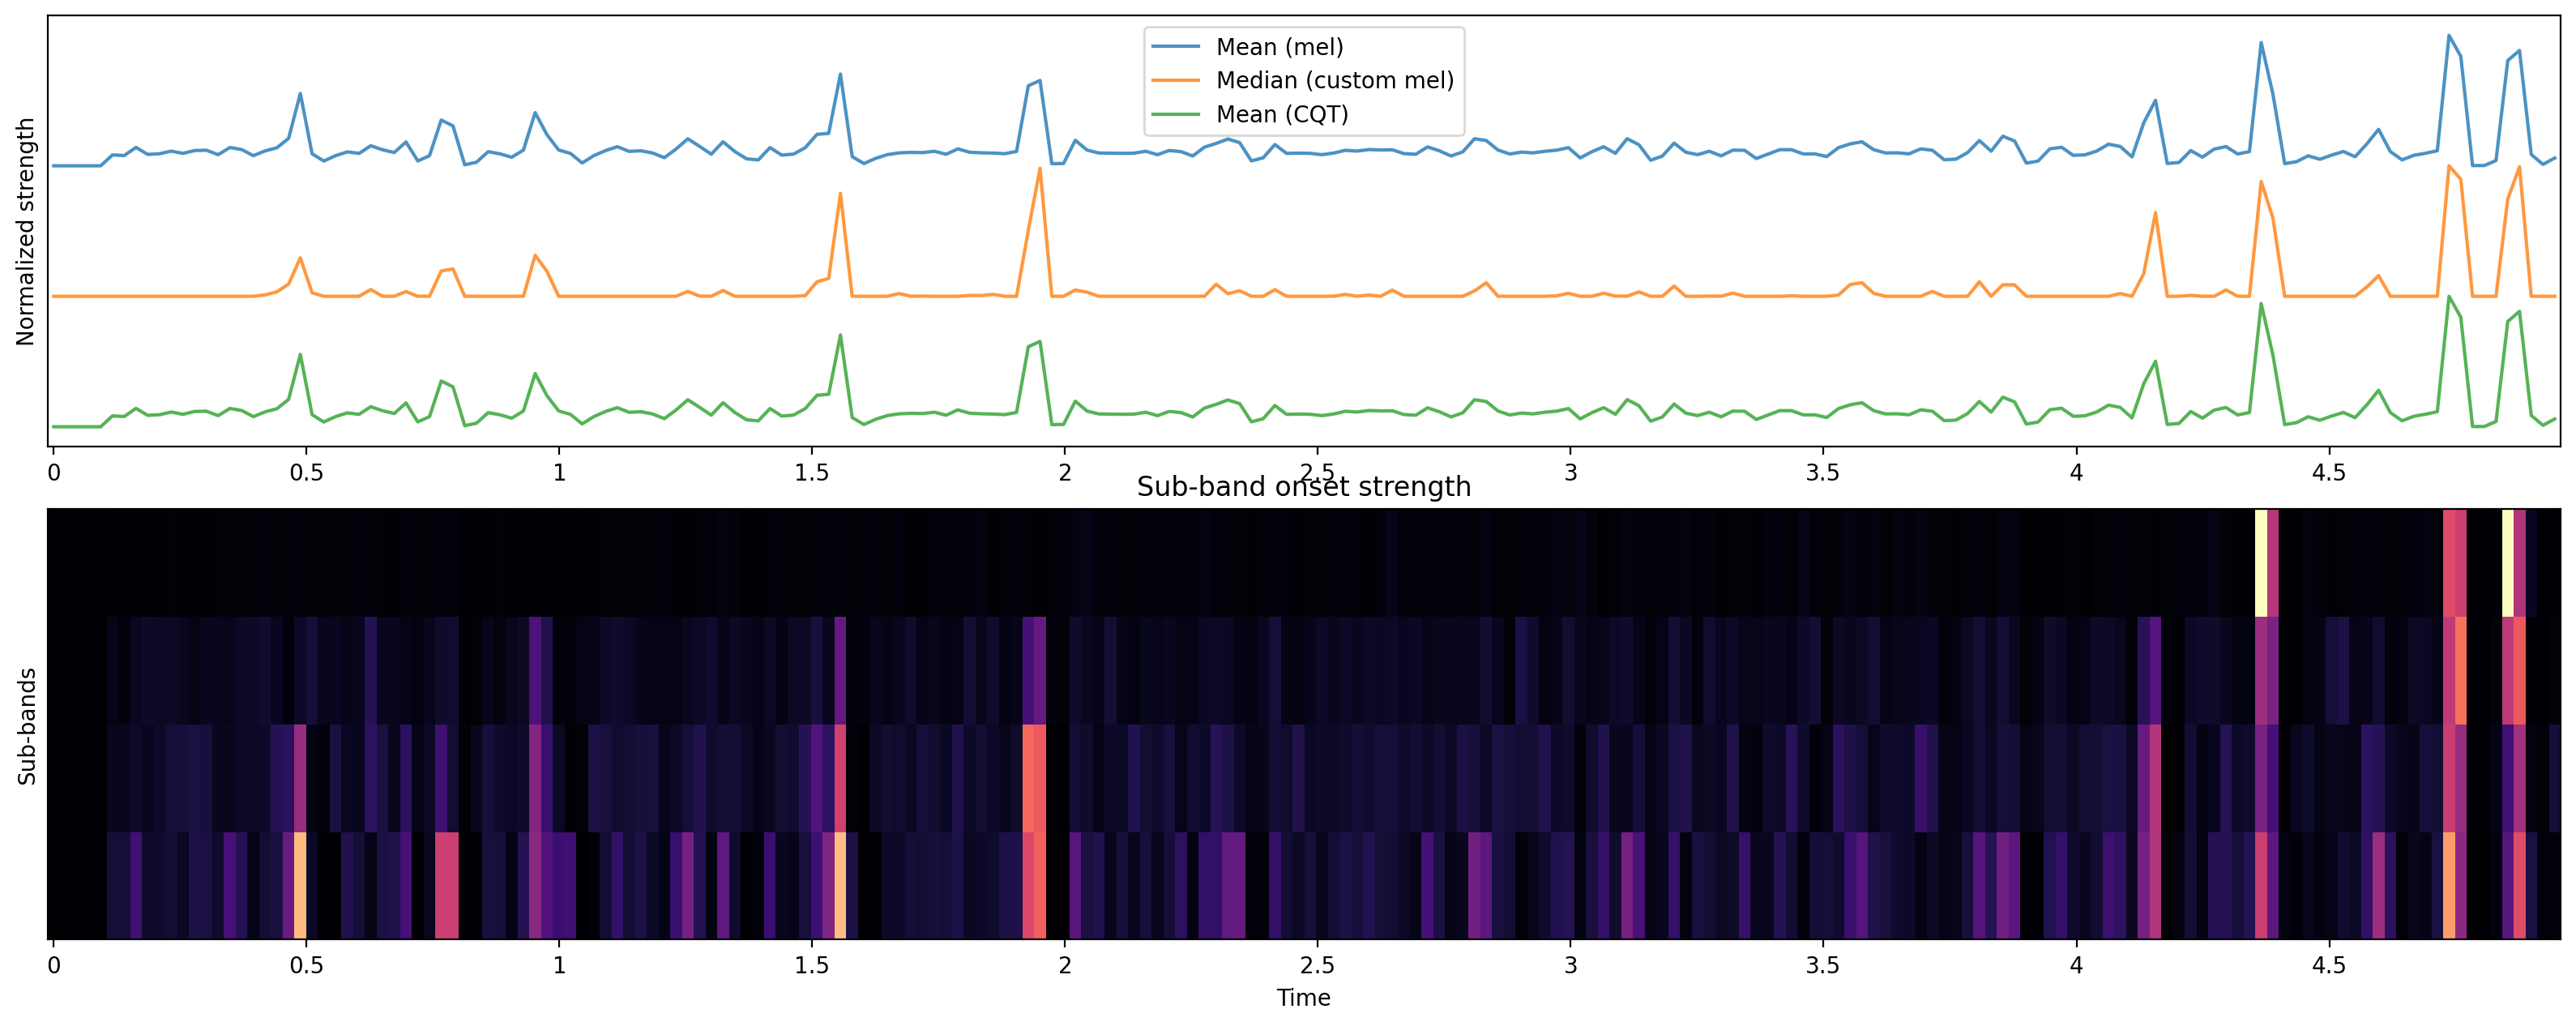

In [40]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))
#ax1 = plt.subplot(2, 1, 1)
#librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),y_axis='log', x_axis='time')
#plt.title('Power spectrogram')

# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr,aggregate=np.median,fmax=8000, n_mels=256)
plt.plot(times, 1+ (onset_env/onset_env.max()), alpha=0.8,label='Median (custom mel)')

# Constant-Q spectrogram instead of Mel
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.plot(times, onset_env / onset_env.max(), alpha=0.8,label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
#plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')

**Loading Data**

In [41]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=",
      len(train_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


In [42]:
from numpy.ma.core import size
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast')
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length = int(sr*duration)
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration )
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(data=X, size=input_length)
            #normalized raw audio
            # y = audio_norm(y)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)
            print(mfccs)
        feature = np.array(mfccs).reshape((-1,1))
        data.append(feature)
    return data

In [43]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 2}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [44]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder=INPUT_DIR+'/set_app/'
# set-Phone Applicaton
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_app'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_app'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_app'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_app'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_app'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-app")

load file  /content/heartsound/input/set_app/artifact__201106111119.wav
fixing audio lenght : artifact__201106111119.wav
load file  /content/heartsound/input/set_app/artifact__201106161016.wav
fixing audio lenght : artifact__201106161016.wav
load file  /content/heartsound/input/set_app/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  /content/heartsound/input/set_app/artifact__201106040722.wav
fixing audio lenght : artifact__201106040722.wav
load file  /content/heartsound/input/set_app/artifact__201106131834.wav
fixing audio lenght : artifact__201106131834.wav
load file  /content/heartsound/input/set_app/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  /content/heartsound/input/set_app/artifact__201106121242.wav
fixing audio lenght : artifact__201106121242.wav
load file  /content/heartsound/input/set_app/artifact__201106101955.wav
fixing audio lenght : artifact__201106101955.wav
load file  /content/heartsound/i

In [45]:
%%time
# load dataset-clinic, keep them separate for testing purpose
B_folder=INPUT_DIR+'/set_clinic/'
# set-Hospitial Clinic Set

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_clinic'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_clinic'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_clinic'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_clinic'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-Clinic")

load file  /content/heartsound/input/set_clinic/murmur__197_1308141235553_D.wav
load file  /content/heartsound/input/set_clinic/murmur__162_1307101835989_A.wav
load file  /content/heartsound/input/set_clinic/murmur_noisymurmur_160_1307100683334_D.wav
fixing audio lenght : murmur_noisymurmur_160_1307100683334_D.wav
load file  /content/heartsound/input/set_clinic/murmur_noisymurmur_171_1307971016233_D.wav
fixing audio lenght : murmur_noisymurmur_171_1307971016233_D.wav
load file  /content/heartsound/input/set_clinic/murmur__244_1309198148498_B.wav
fixing audio lenght : murmur__244_1309198148498_B.wav
load file  /content/heartsound/input/set_clinic/murmur_noisymurmur_164_1307106095995_C1.wav
fixing audio lenght : murmur_noisymurmur_164_1307106095995_C1.wav
load file  /content/heartsound/input/set_clinic/murmur__196_1308141034858_C.wav
load file  /content/heartsound/input/set_clinic/murmur__292_1311185449649_B.wav
fixing audio lenght : murmur__292_1311185449649_B.wav
load file  /content/he

In [46]:
#combine set-app and set-clinic
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds,
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined data record: ",len(y_data), len(test_y))

combined data record:  585 247


In [47]:
# shuffle - whether or not to shuffle the data before splitting.
#           If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator;
#           If RandomState instance, random_state is the random number generator;
#           If None, the random number generator is the RandomState instance used by np.random.

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9,
                                                    random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9,
                                                  random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y = np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [48]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  4680
0

audio data shape:  (585, 40, 1)
data size of the array: : 23400
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  93600

training data shape:  (473, 40, 1)
training label shape:  (473, 3)

validation data shape:  (53, 40, 1)
validation label shape:  (53, 3)

test data shape:  (59, 40, 1)
test label shape:  (59, 3)


**Build Model**

In [49]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics

print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,
               input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 29411 (114.89 KB)
Trainable params: 29411 (114.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train Model**

In [50]:
%%time
# saved model checkpoint file
best_model_file="/content/heartsound/output/heartsounddata.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train,
                  batch_size=MAX_BATCH,
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback)

print ("training finised!")

training started..... please wait.

Epoch 1: loss improved from inf to 0.99199, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 2: loss improved from 0.99199 to 0.80446, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 3: loss improved from 0.80446 to 0.75618, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 4: loss improved from 0.75618 to 0.72427, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 5: loss improved from 0.72427 to 0.71033, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 6: loss improved from 0.71033 to 0.70158, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 7: loss improved from 0.70158 to 0.69525, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 8: loss improved from 0.69525 to 0.69162, saving model to /content/heartsound/output/heartsounddata.hdf5

Epoch 9: loss improved from 0.69162 to 0.67675, saving model to /content

In [51]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0)
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0)
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0)
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0)
print ("model unlabeled data score   : ", round(score[1]*100), "%")

model train data score       :  70 %
model test data score        :  68 %
model validation data score  :  77 %
model unlabeled data score   :  78 %


<Figure size 2200x1000 with 0 Axes>

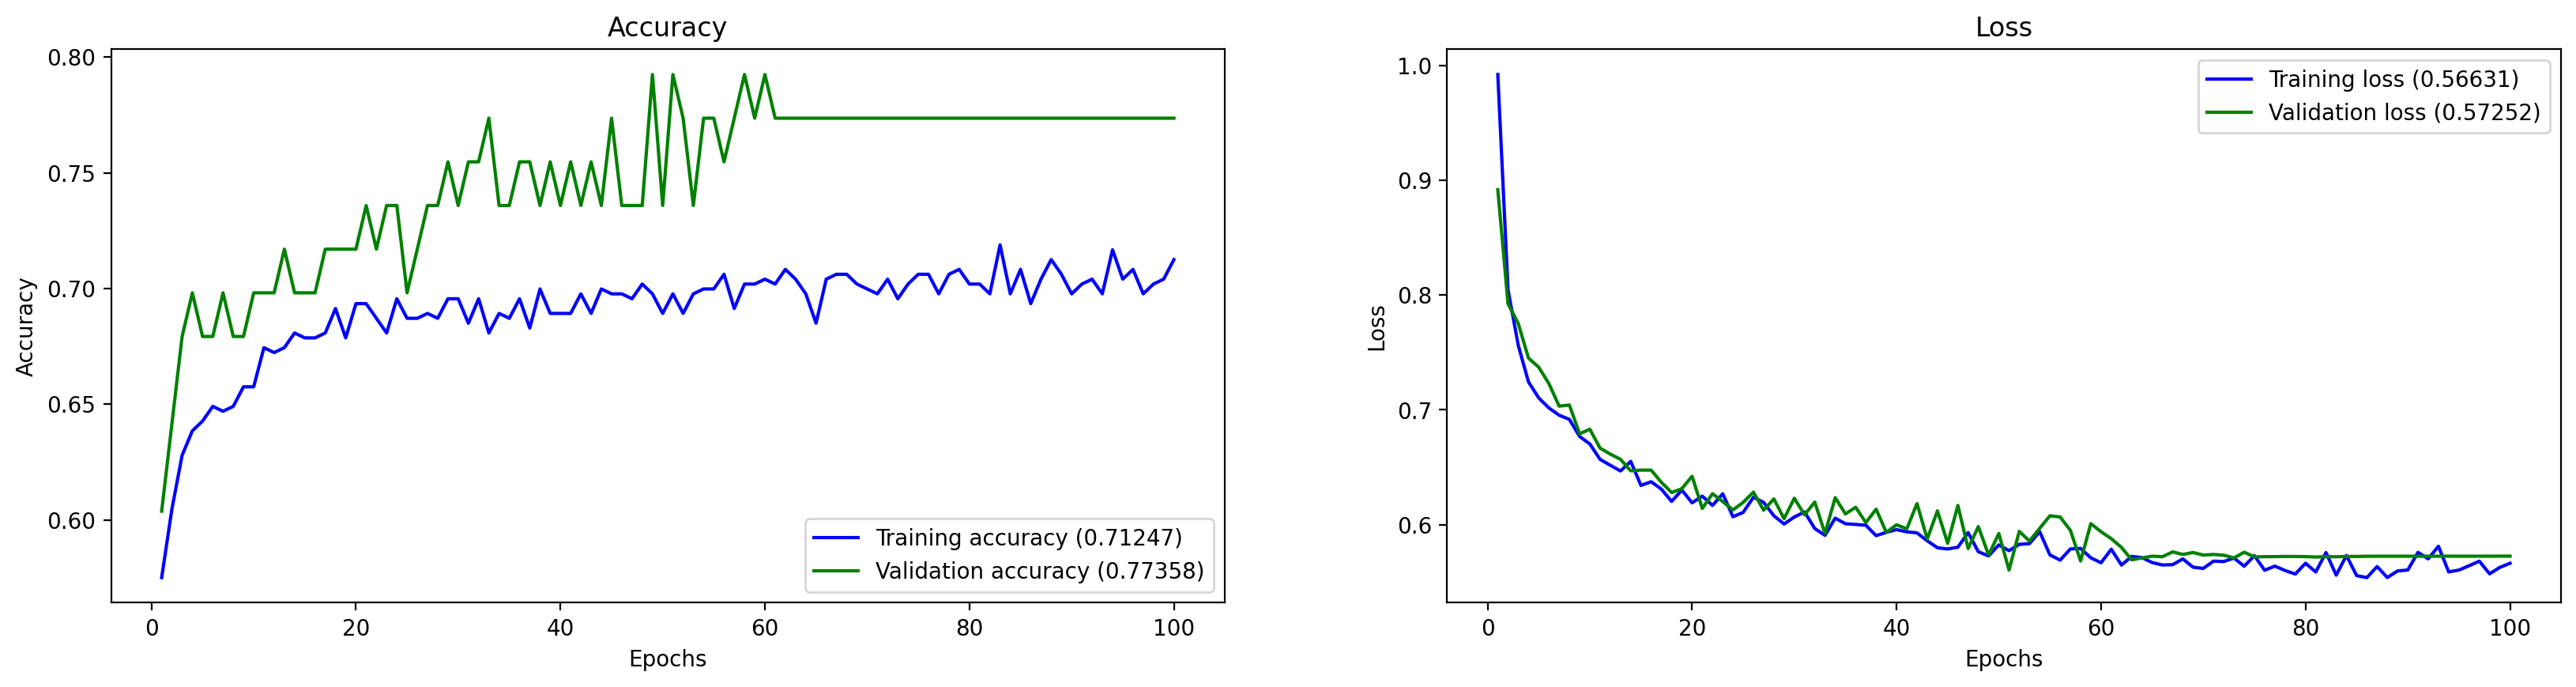

CPU times: user 642 ms, sys: 128 ms, total: 770 ms
Wall time: 670 ms


In [52]:
%%time
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b',
                 label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [54]:
int_to_label = {0: 'artifact', 1: 'murmur', 2: 'normal'}

# prediction class
# Assuming x_test is the data you want to make predictions on
y_pred = model.predict(x_test, batch_size=32)
y_pred_classes = y_pred.argmax(axis=-1)


print("prediction test return:", y_pred_classes[0], "-", int_to_label[y_pred_classes[0]])

2/2 [==============================] - 1s 17ms/step
prediction test return: 2 - normal


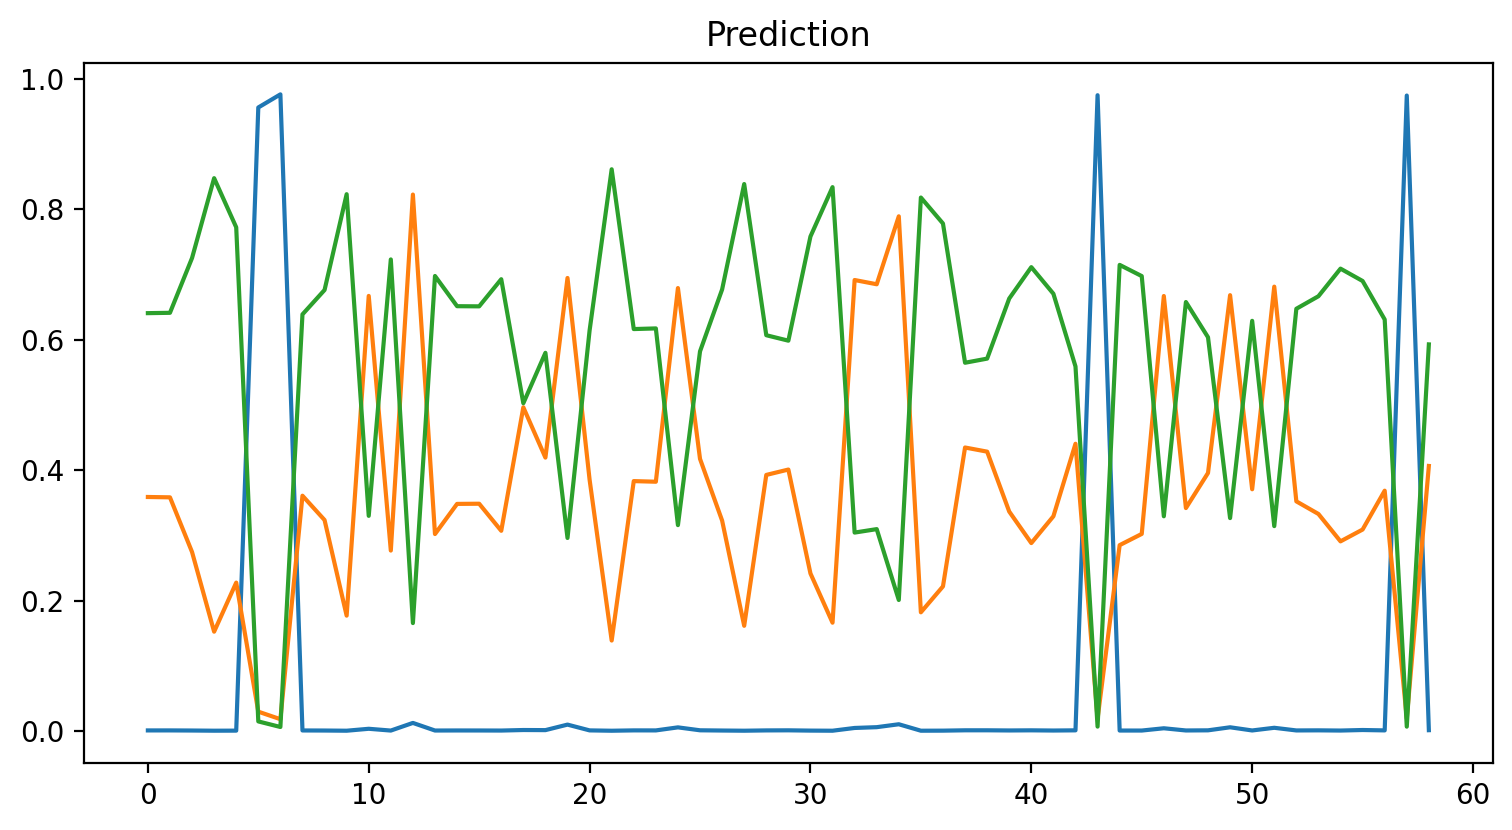

In [55]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

In [56]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 29411 (114.89 KB)
Trainable params: 29411 (114.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Created model and loaded weights from file


In [57]:
import numpy as np
from keras.models import load_model
import tensorflow as tf

# Load the model
model = load_model('/content/heartsound/output/heartsounddata.hdf5')

# Example test data (replace this with your actual test data)
x_test = np.random.rand(3, 218903)  # Example test data with shape (3, 218903)

# Process the test data to match the model's input shape
x_test_processed = x_test[:, :40]  # Extract the first 40 features for each sample
x_test_processed = np.expand_dims(x_test_processed, axis=-1)  # Add a new axis to match (None, 40, 1)

# Define a TF function for prediction using the model directly
@tf.function
def predict_with_model(x):
    return model(x)

# Make predictions using the optimized function
y_pred = predict_with_model(x_test_processed)

# Assuming y_test contains labels in categorical form (shape: (None,))
# Replace this with your actual y_test data
y_test = np.array([2])  # Example categorical labels

# Get the class with the highest probability for each sample
y_pred_classes = np.argmax(y_pred, axis=-1)

# Check the accuracy
accuracy = np.mean(y_pred_classes == y_test)
print("Model evaluation accuracy: ", round(accuracy * 100), "%")

Model evaluation accuracy:  100 %
